In [1]:
# 1

########## 12 March 2019 - Alec S. Hirschauer ##########
# Having presented my work at the Dusting the Universe 
# conference in Tucson, AZ from March 4th to March 9th,
# I have a solid procedure for identifying dusty stars.
#
# The thing I want to change with this notebook is that
# earlier, for CMDs 1 & 2, I failed to establish the
# TRGBs or subsequent bins and color-cut boundaries with
# data that had been trimmed of sources with high
# photometric errors (> 0.1 dex).
#
# When I noticed this the last time, I checked the TRGB
# values and found that the difference that it makes is
# basically negligible, and that the subsequent change
# in the bins and catalogs should also be negligible.
#
# But for the sake of consistency and completeness,
# I have decided to re-do everything for these two CMDs.
#
# The procedures will be the same as from the "20Feb2019"
# notebooks, from which I will be copying a lot of material.

In [2]:
# 2

# First thing needed is to import the relevant Python libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import gaussian_kde
# This line is necessary for the number density histograms.
from astropy import stats
from astropy.stats.histogram import knuth_bin_width
# This line is necessary for determining histogram bin width.
from sklearn import neighbors
from scipy.signal import savgol_filter
# These lines are from Sundar's KDE routine

In [3]:
# 3

# Read in my data from a .csv file saved locally.
phot_data = pd.read_csv('CMDKhanANDSibbonsHOME_ahirschauer.csv')
# This is a table of values with 30,745 rows which contains the photometric data of
# the Khan et al. (2015) catalog matched to sources from Sibbons et al. (2012)
# with an "OR" command, then downloaded from MAST CasJobs.
# print phot_data
#
# Also I'll read in the entire Sibbons+ stellar source catalog.
Sibbons_data = pd.read_csv('Sibbons2012NGC6822.csv')
# This is for a test of the histogram(s) I make later on.

In [4]:
# 4

# For the histograms, I have created new .csv files which have the specific colors'
# information: ID, RA, Dec, magnitudes, magnitude errors, color, color error.
#
# I have pre-trimmed the bogus data from these tables already, so there's no need
# to get rid of the whacky 'null' values converted to "-9999" values
# (which, when subtracted from any other value, gives another bogus value)
# like I did in the previous cell with the "full" catalog.
#
jMINUSkDATA = pd.read_csv('jMINUSk.csv')
jMINUSthreesixDATA = pd.read_csv('jMINUSthreesix.csv')
threesixMINUSeightzeroDATA = pd.read_csv('threesixMINUSeightzero.csv')
jMINUSeightzeroDATA = pd.read_csv('jMINUSeightzero.csv')
eightzeroMINUStwentyfourDATA = pd.read_csv('eightzeroMINUStwentyfour.csv')
fourfiveMINUSeightzeroDATA = pd.read_csv('fourfiveMINUSeightzero.csv')
threesixMINUSfourfiveDATA = pd.read_csv('threesixMINUSfourfive.csv')
#
# ^ Note that only the first file is necessary for THIS notebook.

In [5]:
# 5

# The first thing I'll do here is make the J vs J-K CMD & Hess diagram.

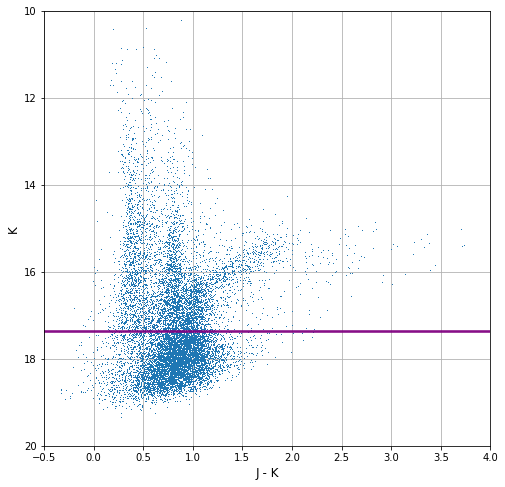

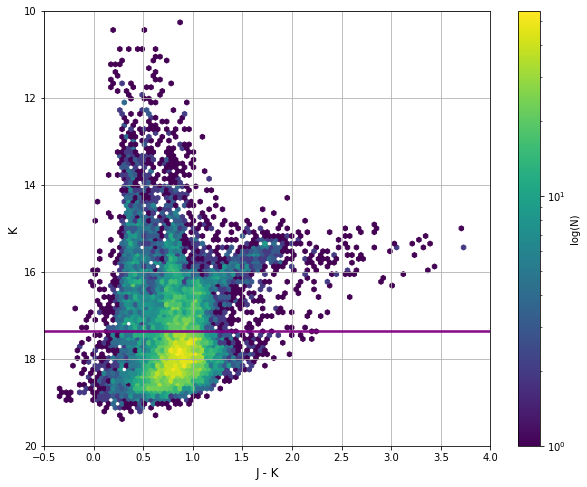

In [6]:
# 6

# K vs J-K
# CMD & Hess diagram
#
plt.figure(figsize=(8,8))
plt.plot(jMINUSkDATA.jMINUSk, jMINUSkDATA.Kmag, ',')
# ^ for presentation plots, change the ',' to a '.'
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - K', size=12)
plt.ylabel('K', size=12)
plt.axhline(y=17.386, linewidth=1.5, color='purple') # TRGB threshold (all points)
plt.axhline(y=17.361, linewidth=1.5, color='purple') # TRGB threshold (only low-error)
plt.grid(True)
plt.show()
plt.close()
#plt.savefig('K_vs_J-K_plot.png')
#
fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
im1 = ax1.hexbin(jMINUSkDATA.jMINUSk, jMINUSkDATA.Kmag, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-0.5, 4.0, 20.0, 10.0))
ax1.set_xlabel('J - K', size=12)
ax1.set_ylabel('K', size=12)
plt.axhline(y=17.386, linewidth=1.5, color='purple') # TRGB threshold (all points)
plt.axhline(y=17.361, linewidth=1.5, color='purple') # TRGB threshold (only low-error)
cb = plt.colorbar(im1, label='log(N)')
plt.grid(True)
plt.show()
plt.close()
#plt.savefig('K_vs_J-K_hist.png')

In [7]:
# 7

# The second thing I'll do is determine where the TRGB should be.
#
# Sibbons et al. (2012) determined it to be at K_0 = 17.41 +/- 0.11,
# and since I'm using their data that seems like a good starting point.
#
# To do so, I'll isolate only the photometric data of sources with
# errors in the magnitudes less than 0.1.

low_error_jMINUSkDATA = jMINUSkDATA[(jMINUSkDATA.eJmag < 0.1) & (jMINUSkDATA.eKmag < 0.1)]

# And as a check, see what the number of sources is for the entire catalog
# versus the number of sources in this trimmed catalog.

print (len(jMINUSkDATA))
print (len(low_error_jMINUSkDATA))

13351
8504


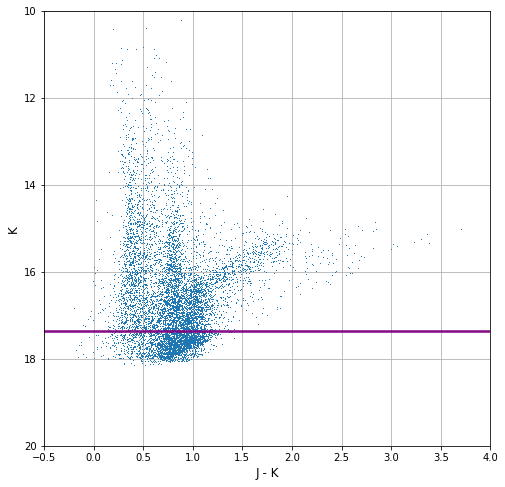

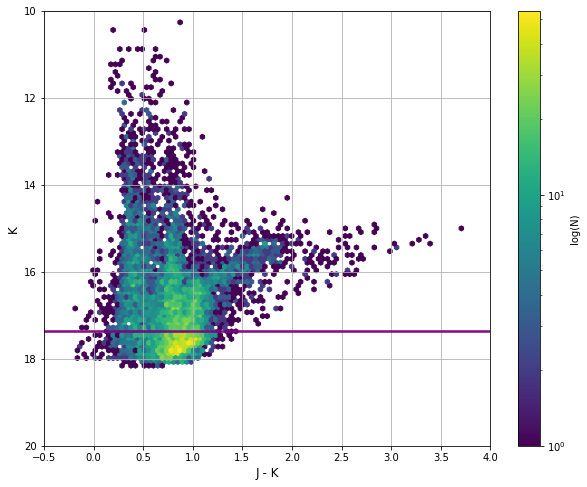

In [8]:
# 8

# With my catalog of only low-error photometry sources, I'll make a
# new CMD and Hess diagram just to see how the data look now.

# K vs J-K (low error)
# CMD & Hess diagram
#
plt.figure(figsize=(8,8))
plt.plot(low_error_jMINUSkDATA.jMINUSk, low_error_jMINUSkDATA.Kmag, ',')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
#plt.xlim(0.5, 1.5)
#plt.ylim(18.0, 16.0)
plt.xlabel('J - K', size=12)
plt.ylabel('K', size=12)
plt.axhline(y=17.386, linewidth=1.5, color='purple') # TRGB threshold (all points)
plt.axhline(y=17.361, linewidth=1.5, color='purple') # TRGB threshold (only low-error)
plt.grid(True)
plt.show()
plt.close()
#plt.savefig('low_error_K_vs_J-K_plot.pdf')
#
fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
#plt.xlim(0.5, 1.5)
#plt.ylim(18.0, 16.0)
im1 = ax1.hexbin(low_error_jMINUSkDATA.jMINUSk, low_error_jMINUSkDATA.Kmag, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-0.5, 4.0, 20.0, 10.0))
ax1.set_xlabel('J - K', size=12)
ax1.set_ylabel('K', size=12)
plt.axhline(y=17.386, linewidth=1.5, color='purple') # TRGB threshold (all points)
plt.axhline(y=17.361, linewidth=1.5, color='purple') # TRGB threshold (only low-error)
cb = plt.colorbar(im1, label='log(N)')
plt.grid(True)
plt.show()
plt.close()
#plt.savefig('low_error_K_vs_J-K_hist.pdf')

In [9]:
# 9

# Definitely looks cleaner than before.
#
# I'll use this trimmed catalog to develop the color cuts themselves,
# but the full catalog when I'm doing the actual source identification.
#
##################################################

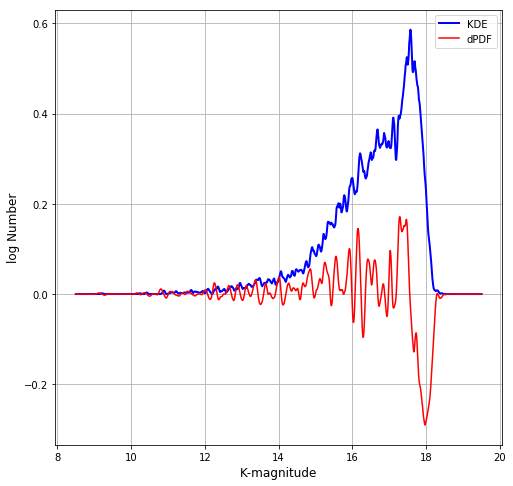

In [10]:
# 10

# This cell shows the non-MC KDE for TRGB determination.
#
# We used this to inform how the multiple realizations of the method
# would work out, even though the MCKDE code looks a bit different.
#
# Once I make the vertical magnitude span bins, I intend to copy
# the code from this cell in order to determine where the breaks
# are in between stellar types, rather than the original KDE
# syntax that was supplied to me by Owen Boberg last year.
#
# If I can't figure out how to get it to work, however, I will fall back
# on the method I used pre-AAS meeting.

def getdata():
    infile = 'jMINUSk.csv'
    #table = np.genfromtxt(infile, delimiter = ',')#, dtype = 'i8, f8, f8, f8, f8, f8, f8, f8, f8')
    table = np.genfromtxt(infile, delimiter = ',', skip_header = 1, dtype = \
                          [('ID', 'i8'), ('RA', 'f8'), ('DEC', 'f8'), ('Jmag', 'f8'), ('eJmag', 'f8'), \
                           ('Kmag', 'f8'), ('eKmag', 'f8'), ('jMINUSk', 'f8'), ('ejMINUSk', 'f8')]) 
    m = table['Kmag']
    dm = table['eKmag']
    return m, dm

def doplot(x, pdfx, dpdfx, data = 0):
    plt.figure(figsize = (8,8))
    plt.plot(x, pdfx, 'k', lw = 2., label = 'KDE', color='blue')
#    if data != 0:
#        plt.hist(data, bins = bins, normed = True, label = 'Binned data')
#    plt.xlim(xlim)
    plt.plot(x, dpdfx*20, 'k', lw = 1.5, label = 'dPDF', color='red')
    plt.legend()
    #plt.axvline(x=17.41, linewidth=1.5, color='lightblue') # Sibbons+ (2012) TRGB value
    #plt.axvline(x=16.955, linewidth=1.5, color='lightgreen') # TRGB value determined from earlier work
    plt.xlabel('K-magnitude', size=12)
    plt.ylabel('log Number', size=12)
    plt.grid(True)
    plt.show()
    plt.close()
    #plt.savefig('CMD1_KDE.pdf')

def main():

    #Read from input table into variables m and dm
    # m, dm = getdata(infile = infile)
    #m = jMINUSkHIST.Kmag
    #dm = jMINUSkHIST.eKmag
    m = low_error_jMINUSkDATA.Kmag
    dm = low_error_jMINUSkDATA.eKmag

    #Initialise stuff
    rtol = 1e-5
    kernel = 'epanechnikov' #parabolic kernel
    #mx = np.linspace(min(m)*0.8, max(m)*1.2, 1000)
    mx = np.linspace(8.5, 19.5, 1000)
    #Generate NITER realisations of the KDE

#    for i in range(niter):
    msamp = np.random.normal(m, dm)
    #print(min(msamp))
        #PS: Monte Carlo already smooths the distribution, so reduce the ideal binwidth a bit.
    bandwidth_factor = 0.25
    bandwidth = bandwidth_factor*(np.std(msamp)*(len(msamp)**(-0.2)))
        #Requires you to define the BANDWIDTH and KERNEL variables before this line.
    kde = neighbors.KernelDensity(bandwidth = bandwidth, rtol = rtol, kernel = kernel)
    kde.fit(msamp[:, np.newaxis])
        #MX is the x axis range over which the PDF is computed/plotted.
    pdf = kde.score_samples(mx[:, np.newaxis])
    pdf = np.exp(pdf)
    dpdf = np.gradient(pdf, mx[1] - mx[0]) #mx is equally spaced, provide the spacing as the x difference.
    from scipy.signal import savgol_filter
    pdfsm = savgol_filter(pdf, 3, 2, deriv = 0)
    dpdfsm = savgol_filter(pdf, 31, 3, deriv = 1) 
    # ^ smoothing window should be somehow related to resolution used for x axis
 #       #Plotting
    doplot(mx, pdf, dpdfsm)
    #print(pdf)
    #print(bandwidth)
 #       #Use PDF to do stuff (e.g., detect edges)
 #       #result = do_stuff(pdf)
 #       #Store results of ith iteration
 #       #
 #       #

main()

###TBD:
##1. Plot N visualisations on same plot
##2. Store all PDFs/derivatives and find average of N visualisations and plot that.
##3. Manual cut at K=18 to preserve strongest *positive* derivative.

(17.36121281361361, 0.03336553816100012)

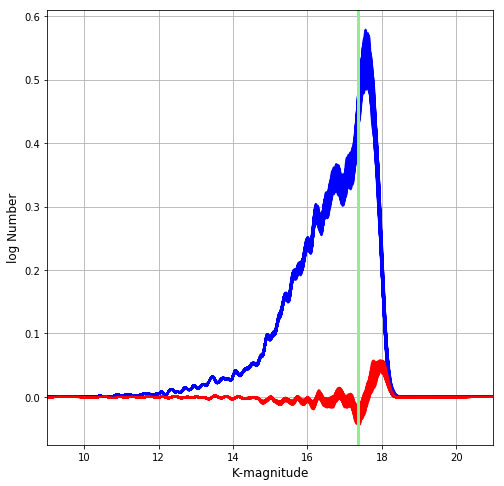

In [11]:
# 11

# This cell contains the MCKDE code routine to find the TRGB
# which we are intending on implementing for finding the breaks
# between different stellar types.
#
# Our problem so far has been twofold:
#
# (1) By realizing each time a thousand times, we are giving the
#     analysis a large number of opportunities to explore unlikely
#     paths, and so the resulting unertainties are extremely large.
#
#     Sundar has talked to Peter about this, realizing that what
#     we really should do is find the "natural width" of the
#     distributions, which is an estimate of the standard deviations,
#     which is the 68% spread.
#
# (2) The Savitzky-Golay filter (rather than Sobel filter) is used
#     to determine where the maxima in derivative to the Epanechnikov
#     curve fit to the data is located, which is fine for finding the
#     TRGB, but is less obviously usable for finding the local minima
#     of inflection points.

import numpy as np
import matplotlib.pyplot as plt
from sklearn import neighbors
from scipy.signal import savgol_filter

def getdata(infile = 'jMINUSk.csv', magname = 'Kmag', dmagname = 'eKmag'):
    #table = np.genfromtxt(infile, delimiter = ',')#, dtype = 'i8, f8, f8, f8, f8, f8, f8, f8, f8')
    table = np.genfromtxt(infile, delimiter = ',', skip_header = 1, dtype = \
                          [('ID', 'i8'), ('RA', 'f8'), ('DEC', 'f8'), ('Jmag', 'f8'), ('eJmag', 'f8'), \
                           ('Kmag', 'f8'), ('eKmag', 'f8'), ('jMINUSk', 'f8'), ('ejMINUSk', 'f8')]) 
    m = table[magname]
    dm = table[dmagname]
    return m, dm

def doplot(x, pdfx, deriv = 0, data = 0, first = True, last = False):
    if first: plt.figure(figsize = (8,8))
    plt.plot(x, pdfx, 'k', lw = 2, label = 'KDE', color='blue')
    #if len(data) != 1 and data[0] != 0:
    #    plt.hist(data, bins = bins, normed = True, label = 'Binned data')
    try:
        scale = np.max(pdfx)/np.max(deriv)/10.
        plt.plot(x, deriv*scale, 'r', lw = 2, label = 'dKDE', color='red')
    except:
        print('no derivatives specified')
    if last:
        plt.xlabel('K-magnitude', size=12)
        plt.ylabel('log Number', size=12)
        plt.xlim(9.,21.)
        #plt.ylim(-0.075,0.525)
        #plt.axvline(x=17.39, linewidth=3.0, color='lightgreen') # TRGB (all points)
        plt.axvline(x=17.36, linewidth=3.0, color='lightgreen') # TRGB (error > 0.1 dex)
        plt.grid(True)
        #plt.show()
        #plt.close()
        plt.savefig('CMD1_MCKDE_TRGB_paper.pdf')
    #if len(deriv) != 1 and deriv[0] != 0:
    #    scale = np.max(pdfx)/np.max(deriv)
    #    print(scale)
    #    plt.plot(x, deriv*scale, 'k', lw = 3, label = 'dKDE')
    #    #plt.plot(x, deriv, 'r', lw = 2, label = 'dKDE')

def trgbfind(infile = 'jMINUSk.csv', magname = 'Kmag', dmagname = 'eKmag', niter = 1000, kernel = 'gaussian'):

    #Read from input table into variables m and dm
    #m, dm = getdata(infile = infile)
    #m = jMINUSkHIST.Kmag
    #dm = jMINUSkHIST.eKmag
    m = low_error_jMINUSkDATA.Kmag
    dm = low_error_jMINUSkDATA.eKmag

    #Initialise stuff
    niter = 1000
    rtol = 1e-5
    kernel = 'gaussian' #parabolic kernel -> gaussian (30 Oct 2019)
    mx = np.linspace(max(m)*1.2, min(m)*0.8, 1000)
    trgbloc = np.zeros(niter)
    #Generate NITER realisations of the KDE

    for i in range(niter):
        msamp = np.random.normal(m, dm)
        #PS: Monte Carlo already smooths the distribution, so reduce the ideal binwidth a bit.
        bandwidth_factor = 0.25
        bandwidth = bandwidth_factor*(np.std(msamp)*(len(msamp)**(-0.2)))
        #Requires you to define the BANDWIDTH and KERNEL variables before this line.
        kde = neighbors.KernelDensity(bandwidth = bandwidth, rtol = rtol, kernel = kernel)
        kde.fit(msamp[:, np.newaxis])
        #MX is the x axis range over which the PDF is computed/plotted.
        #kde.score_samples returns ln(pdf)
        pdf = np.exp(kde.score_samples(mx[:, np.newaxis]))
        smooth_window = 31
        poly_degree = 3
        dpdf = savgol_filter(pdf, smooth_window, poly_degree, deriv = 1)
        trgbloc[i] = mx[np.argmin(dpdf)] #Most negative value corresponds to highest rate of decrease 
        #Plotting
        doplot(mx, pdf, deriv = dpdf, data = msamp, first = i == 0, last = i == niter - 1)
        #Use PDF to do stuff (e.g., detect edges)
        #result = do_stuff(pdf)
        #Store results of ith iteration
        #
        #

    trgbloc_mean = np.mean(trgbloc)
    trgbloc_sd = np.std(trgbloc)
    return trgbloc_mean, trgbloc_sd
    #print(trgbloc_mean, trgbloc_sd) # this does the same as the above, just differently

trgbfind()


In [12]:
# 12

# Now that I have the TRGB value and error for the low-error sources,
# I can make the magnitude-span boxes of n = 1,000 sources
# and their associated KDEs, for which I'll evaluate the local minima.

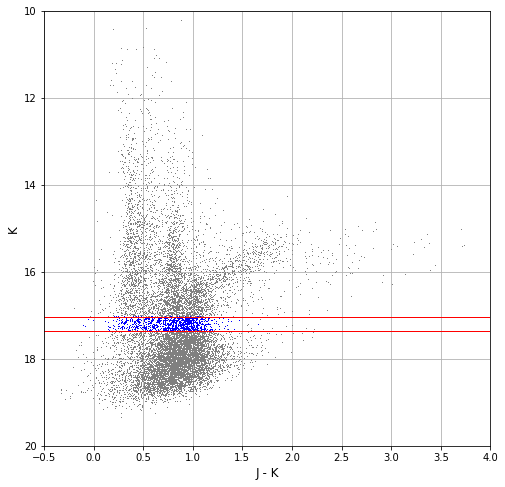

1010
0.07358333333333333
17.363
17.043


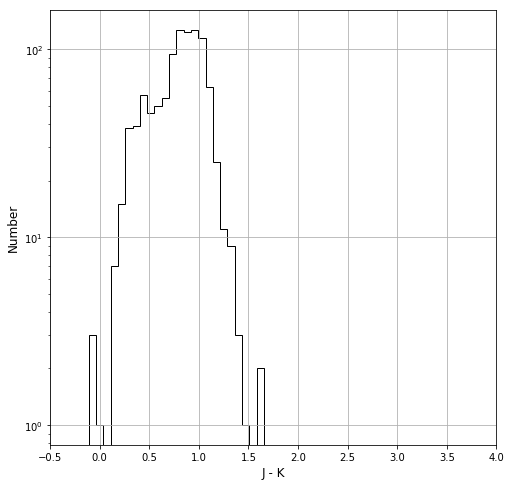

In [13]:
# 13 (Bin 1)

# Here I'm making the CMD of *ONLY* the sources within the first bin above the TRGB.
# Also I'm making a histogram of said sources.

TRGB = 17.363
initial_width = 0.500
width_change = 0.010

jMINUSkHIST = low_error_jMINUSkDATA[(low_error_jMINUSkDATA.Kmag < (TRGB))
                                    & (low_error_jMINUSkDATA.Kmag > (TRGB-initial_width*1.+width_change*18.))]

bin_end = TRGB-initial_width*1.+width_change*18.

plt.figure(figsize=(8,8))
plt.plot(jMINUSkDATA.jMINUSk, jMINUSkDATA.Kmag, ',', color='gray')
plt.plot(jMINUSkHIST.jMINUSk, jMINUSkHIST.Kmag, ',', color='blue')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - K', size=12)
plt.ylabel('K', size=12)
#
plt.axhline(y=TRGB, linewidth=1.0, color='red') # Bin 1 - lower boundary
plt.axhline(y=bin_end, linewidth=1.0, color='red') # Bin 1 - upper boundary
#
plt.grid(True)
plt.show()
plt.close()

# define the range of K-band magnitudes over which the bin is sampling
# from the catalog of sources with K-mag and J-mag errors less than 0.1.
#
#print jMINUSkHIST
print(len(jMINUSkHIST))
#
binwidth = stats.knuth_bin_width(jMINUSkHIST.jMINUSk)
bin_number = (max(jMINUSkHIST.jMINUSk)+binwidth)/binwidth
print(binwidth)
#print bin_number
#
print(TRGB)
print(bin_end)
#
fig = plt.figure(figsize = (8,8))
plt.hist(jMINUSkHIST.jMINUSk, bins=np.arange(min(jMINUSkHIST.jMINUSk), max(jMINUSkHIST.jMINUSk) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-0.5, 4.0)
plt.xlabel('J - K', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

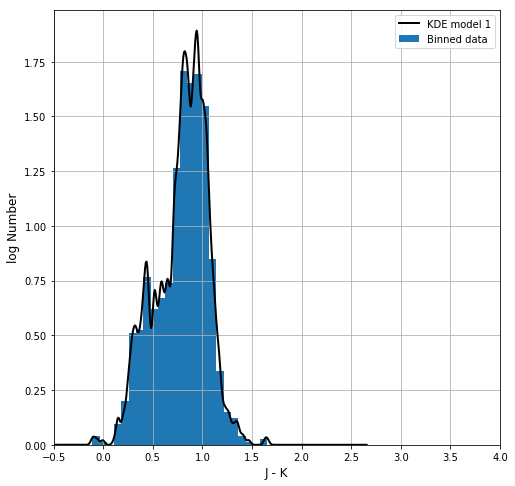

In [14]:
# 14 (Bin 1)

# K = 17.363 to 17.043
#
kde_data = jMINUSkHIST.jMINUSk.values
bins=np.arange(min(kde_data ), max(kde_data ) + binwidth, binwidth)
x_eval = np.linspace(kde_data.min() - 1.0, kde_data.max() + 1.0, 500)
kde = gaussian_kde(kde_data,bw_method=binwidth)
#
plt.figure(figsize=(8,8))
plt.plot(x_eval, kde(x_eval),'k',lw=2,label='KDE model 1')
plt.hist(kde_data,bins=bins,density=True,label='Binned data')
plt.xlim(-0.5, 4.0)

#plt.xlim(0.482, 0.483)
#plt.ylim(0.533, 0.5335)
#plt.xlim(0.875, 0.885)
#plt.ylim(1.54, 1.56)
#plt.xlim(0.985, 0.990)
#plt.ylim(1.57, 1.59)
#plt.xlim(1.30, 1.31)
#plt.ylim(0.095, 0.105)
#plt.xlim(1.3, 1.6)
#plt.ylim(0.0, 0.1)

plt.legend()
plt.xlabel('J - K', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()
#
### y-intercept: K_0 = 17.203
### boundary 1: J-K = 0.483 ? 0.482
### boundary 2: J-K = 0.883 ? 0.882
### boundary 3: J-K = 0.988 ? 0.988
### boundary 4: J-K = 1.305 ? 1.305

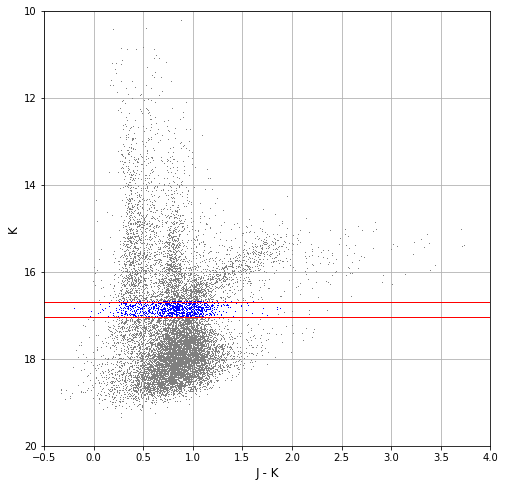

1012
0.06478125000000001
17.043
16.683


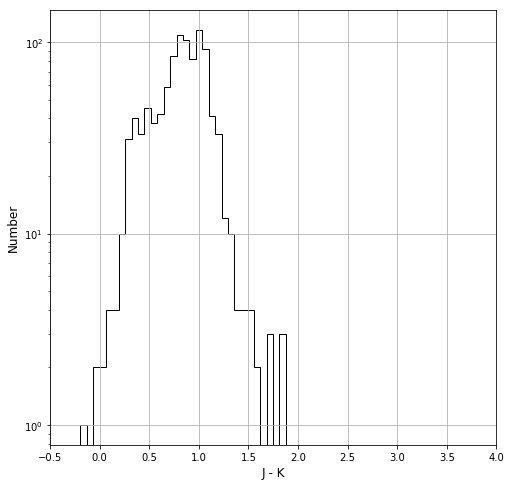

In [15]:
# 15 (Bin 2)

# Here I'm making the CMD of *ONLY* the sources within the second bin above the TRGB.
# Also I'm making a histogram of said sources.

TRGB = 17.043

jMINUSkHIST = low_error_jMINUSkDATA[(low_error_jMINUSkDATA.Kmag < (TRGB))
                                    & (low_error_jMINUSkDATA.Kmag > (TRGB-initial_width*1.+width_change*14.))]

bin_end = TRGB-initial_width*1.+width_change*14.

plt.figure(figsize=(8,8))
plt.plot(jMINUSkDATA.jMINUSk, jMINUSkDATA.Kmag, ',', color='gray')
plt.plot(jMINUSkHIST.jMINUSk, jMINUSkHIST.Kmag, ',', color='blue')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - K', size=12)
plt.ylabel('K', size=12)
#
plt.axhline(y=TRGB, linewidth=1.0, color='red') # Bin 2 - lower boundary
plt.axhline(y=bin_end, linewidth=1.0, color='red') # Bin 2 - upper boundary
#
plt.grid(True)
plt.show()
plt.close()

# define the range of K-band magnitudes over which the bin is sampling
# from the catalog of sources with K-mag and J-mag errors less than 0.1.
#
#print jMINUSkHIST
print(len(jMINUSkHIST))
#
binwidth = stats.knuth_bin_width(jMINUSkHIST.jMINUSk)
bin_number = (max(jMINUSkHIST.jMINUSk)+binwidth)/binwidth
print(binwidth)
#print bin_number
#
print(TRGB)
print(bin_end)
#
fig = plt.figure(figsize = (8,8))
plt.hist(jMINUSkHIST.jMINUSk, bins=np.arange(min(jMINUSkHIST.jMINUSk), max(jMINUSkHIST.jMINUSk) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-0.5, 4.0)
plt.xlabel('J - K', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

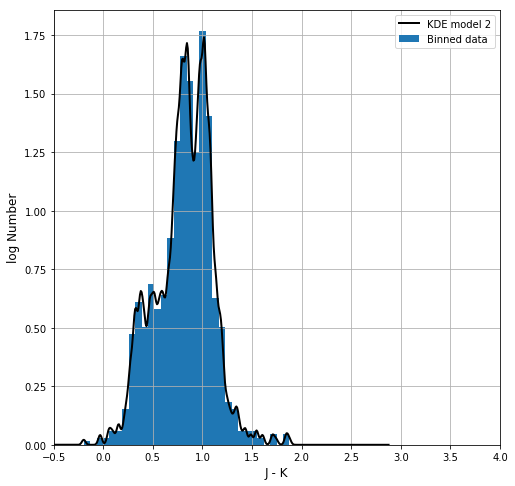

In [16]:
# 16 (Bin 2)

# K = 17.043 to 16.683
#
kde_data = jMINUSkHIST.jMINUSk.values
bins=np.arange(min(kde_data ), max(kde_data ) + binwidth, binwidth)
x_eval = np.linspace(kde_data.min() - 1.0, kde_data.max() + 1.0, 500)
kde = gaussian_kde(kde_data,bw_method=binwidth)
#
plt.figure(figsize=(8,8))
plt.plot(x_eval, kde(x_eval),'k',lw=2,label='KDE model 2')
plt.hist(kde_data,bins=bins,density=True,label='Binned data')
plt.xlim(-0.5, 4.0)

#plt.xlim(0.541, 0.544)
#plt.ylim(0.59, 0.61)
#plt.xlim(0.9, 0.92)
#plt.ylim(1.2, 1.22)
#plt.xlim(1.113, 1.115)
#plt.ylim(0.84, 0.86)
#plt.xlim(1.405, 1.410)
#plt.ylim(0.06, 0.061)

plt.legend()
plt.xlabel('J - K', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()
#
### y-intercept: K_0 = 16.863
### boundary 1: J-K = 0.543 ? 0.543
### boundary 2: J-K = 0.918 ? 0.910
### boundary 3: J-K = 1.084* ? 1.114
### boundary 4: J-K = 1.506 ? 1.408

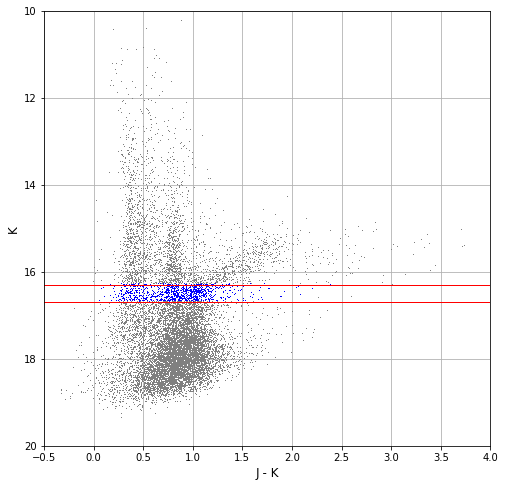

1010
0.091
16.683
16.293


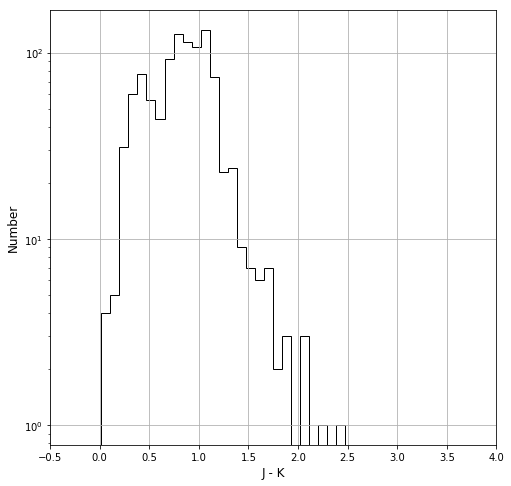

In [17]:
# 17 (Bin 3)

# Here I'm making the CMD of *ONLY* the sources within the third bin above the TRGB.
# Also I'm making a histogram of said sources.

TRGB = 16.683

jMINUSkHIST = low_error_jMINUSkDATA[(low_error_jMINUSkDATA.Kmag < (TRGB))
                                    & (low_error_jMINUSkDATA.Kmag > (TRGB-initial_width*1.+width_change*10.))]

bin_end = TRGB-initial_width*1.+width_change*11.

plt.figure(figsize=(8,8))
plt.plot(jMINUSkDATA.jMINUSk, jMINUSkDATA.Kmag, ',', color='gray')
plt.plot(jMINUSkHIST.jMINUSk, jMINUSkHIST.Kmag, ',', color='blue')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - K', size=12)
plt.ylabel('K', size=12)
#
plt.axhline(y=TRGB, linewidth=1.0, color='red') # Bin 3 - lower boundary
plt.axhline(y=bin_end, linewidth=1.0, color='red') # Bin 3 - upper boundary
#
plt.grid(True)
plt.show()
plt.close()
#plt.savefig('CMD1_bin3_CMD.png')

# define the range of K-band magnitudes over which the bin is sampling
# from the catalog of sources with K-mag and J-mag errors less than 0.1.
#
#print jMINUSkHIST
print(len(jMINUSkHIST))
#
binwidth = stats.knuth_bin_width(jMINUSkHIST.jMINUSk)
bin_number = (max(jMINUSkHIST.jMINUSk)+binwidth)/binwidth
print(binwidth)
#print bin_number
#
print(TRGB)
print(bin_end)
#
fig = plt.figure(figsize = (8,8))
plt.hist(jMINUSkHIST.jMINUSk, bins=np.arange(min(jMINUSkHIST.jMINUSk), max(jMINUSkHIST.jMINUSk) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-0.5, 4.0)
plt.xlabel('J - K', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

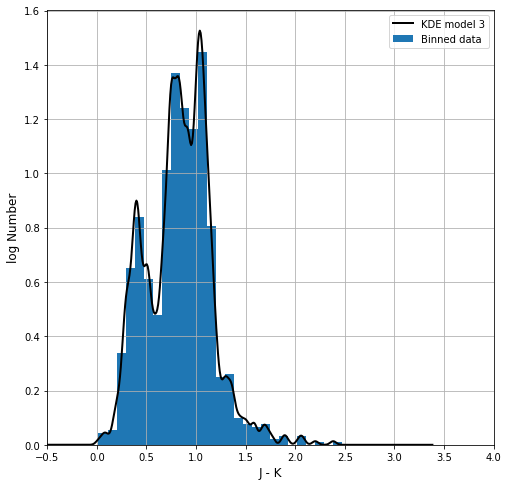

In [18]:
# 18 (Bin 3)

# K = 16.683 to 16.293
#
kde_data = jMINUSkHIST.jMINUSk.values
bins=np.arange(min(kde_data ), max(kde_data ) + binwidth, binwidth)
x_eval = np.linspace(kde_data.min() - 1.0, kde_data.max() + 1.0, 500)
kde = gaussian_kde(kde_data,bw_method=binwidth)
#
plt.figure(figsize=(8,8))
plt.plot(x_eval, kde(x_eval),'k',lw=2,label='KDE model 3')
plt.hist(kde_data,bins=bins,density=True,label='Binned data')
plt.xlim(-0.5, 4.0)

#plt.xlim(0.5915, 0.5925)
#plt.ylim(0.483, 0.4835)
#plt.xlim(0.948, 0.952)
#plt.ylim(1.1, 1.11)
#plt.xlim(1.2625, 1.2675)
#plt.ylim(0.24, 0.2425)
#plt.xlim(1.824, 1.827)
#plt.ylim(0.005, 0.01)

plt.legend()
plt.xlabel('J - K', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()
#plt.savefig('CMD1_bin3_KDE.png')
#
### y-intercept: K_0 = 16.488
### boundary 1: J-K = 0.569 ? 0.592
### boundary 2: J-K = 0.954 ? 0.951
### boundary 3: J-K = 1.256 ? 1.266
### boundary 4: J-K = 1.826 ? 1.826

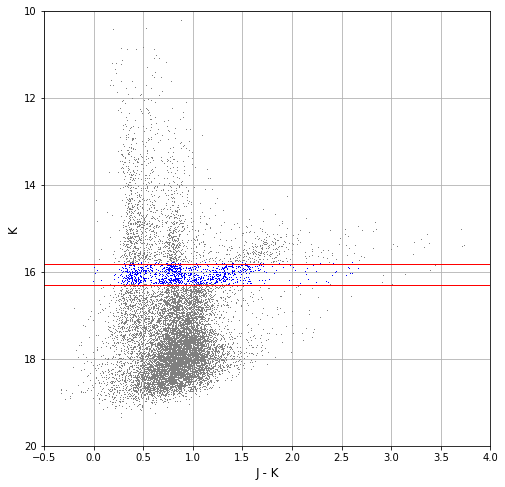

1014
0.11125000000000002
16.293
15.822999999999999


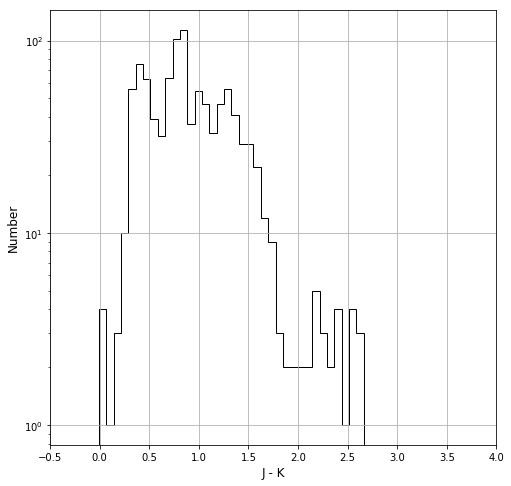

In [19]:
# 19 (Bin 4)

# Here I'm making the CMD of *ONLY* the sources within the fourth bin above the TRGB.
# Also I'm making a histogram of said sources.

TRGB = 16.293

jMINUSkHIST = low_error_jMINUSkDATA[(low_error_jMINUSkDATA.Kmag < (TRGB))
                                    & (low_error_jMINUSkDATA.Kmag > (TRGB-initial_width*1.+width_change*1.))]

bin_end = TRGB-initial_width*1.+width_change*3.

plt.figure(figsize=(8,8))
plt.plot(jMINUSkDATA.jMINUSk, jMINUSkDATA.Kmag, ',', color='gray')
plt.plot(jMINUSkHIST.jMINUSk, jMINUSkHIST.Kmag, ',', color='blue')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - K', size=12)
plt.ylabel('K', size=12)
#
plt.axhline(y=TRGB, linewidth=1.0, color='red') # Bin 4 - lower boundary
plt.axhline(y=bin_end, linewidth=1.0, color='red') # Bin 4 - upper boundary
#
plt.grid(True)
plt.show()
plt.close()
#plt.savefig('CMD1_bin4_CMD.png')

# define the range of K-band magnitudes over which the bin is sampling
# from the catalog of sources with K-mag and J-mag errors less than 0.1.
#
#print jMINUSkHIST
print(len(jMINUSkHIST))
#
binwidth = stats.knuth_bin_width(jMINUSkHIST.jMINUSk)
bin_number = (max(jMINUSkHIST.jMINUSk)+binwidth)/binwidth
print(binwidth)
#print bin_number
#
print(TRGB)
print(bin_end)
#
fig = plt.figure(figsize = (8,8))
plt.hist(jMINUSkHIST.jMINUSk, bins=np.arange(min(jMINUSkHIST.jMINUSk), max(jMINUSkHIST.jMINUSk) + binwidth/1.5, binwidth/1.5), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-0.5, 4.0)
plt.xlabel('J - K', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

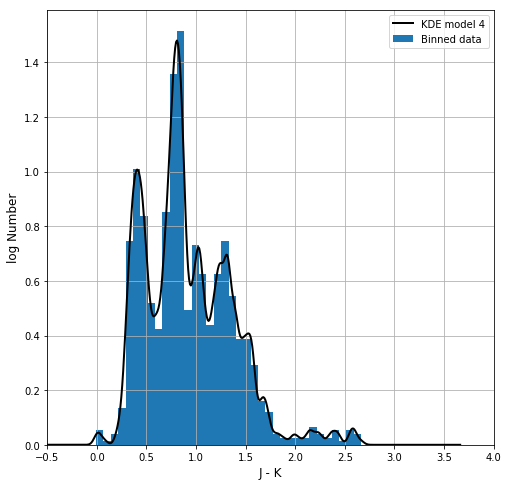

In [20]:
# 20 (Bin 4)

# K = 16.293 to 15.823
#
kde_data = jMINUSkHIST.jMINUSk.values
bins=np.arange(min(kde_data ), max(kde_data ) + binwidth/1.5, binwidth/1.5)
x_eval = np.linspace(kde_data.min() - 1.0, kde_data.max() + 1.0, 500)
kde = gaussian_kde(kde_data,bw_method=binwidth/1.5)
#
plt.figure(figsize=(8,8))
plt.plot(x_eval, kde(x_eval),'k',lw=2,label='KDE model 4')
plt.hist(kde_data,bins=bins,density=True,label='Binned data')
plt.xlim(-0.5, 4.0)

#plt.xlim(0.573, 0.577)
#plt.ylim(0.4675, 0.4725)
#plt.xlim(0.9475, 0.9500)
#plt.ylim(0.582, 0.584)
#plt.xlim(1.125, 1.13)
#plt.ylim(0.452, 0.454)
#plt.xlim(2.30, 2.31)
#plt.ylim(0.023, 0.025)

plt.legend()
plt.xlabel('J - K', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()
#plt.savefig('CMD1_bin4_KDE.png')
#
### y-intercept: K_0 = 16.058
### boundary 1: J-K = 0.612 ? 0.575
### boundary 2: J-K = 0.940 ? 0.949
### boundary 3: J-K = 1.136 ? 1.127
### boundary 4: J-K = 1.894 ? 2.306

Text(0, 0.5, 'log Number')

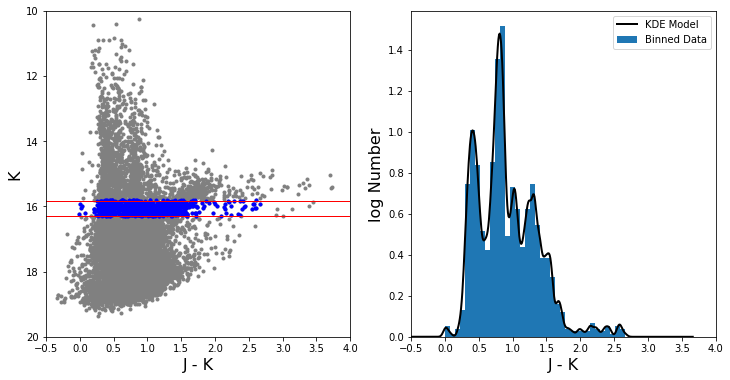

In [21]:
# temp

plt.figure(figsize=(12,6))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

#ax1.figure(figsize=(8,8))
ax1.plot(jMINUSkDATA.jMINUSk, jMINUSkDATA.Kmag, '.', color='gray')
ax1.plot(jMINUSkHIST.jMINUSk, jMINUSkHIST.Kmag, '.', color='blue')
ax1.set_xlim(-0.5, 4.0)
ax1.set_ylim(20.0, 10.0)
ax1.set_xlabel('J - K', size=16)
ax1.set_ylabel('K', size=16)
#
ax1.axhline(y=TRGB, linewidth=1.0, color='red') # Bin 4 - lower boundary
ax1.axhline(y=bin_end, linewidth=1.0, color='red') # Bin 4 - upper boundary

kde_data = jMINUSkHIST.jMINUSk.values
bins=np.arange(min(kde_data ), max(kde_data ) + binwidth/1.5, binwidth/1.5)
x_eval = np.linspace(kde_data.min() - 1.0, kde_data.max() + 1.0, 500)
kde = gaussian_kde(kde_data,bw_method=binwidth/1.5)
#
#ax2.figure(figsize=(8,8))
ax2.plot(x_eval, kde(x_eval),'k',lw=2,label='KDE Model')
ax2.hist(kde_data,bins=bins,density=True,label='Binned Data')
ax2.set_xlim(-0.5, 4.0)

#plt.xlim(0.573, 0.577)
#plt.ylim(0.4675, 0.4725)
#plt.xlim(0.9475, 0.9500)
#plt.ylim(0.582, 0.584)
#plt.xlim(1.125, 1.13)
#plt.ylim(0.452, 0.454)
#plt.xlim(2.30, 2.31)
#plt.ylim(0.023, 0.025)

plt.legend()
ax2.set_xlabel('J - K', size=16)
ax2.set_ylabel('log Number', size=16)

#plt.savefig('CMD_KDE_bin4.pdf')

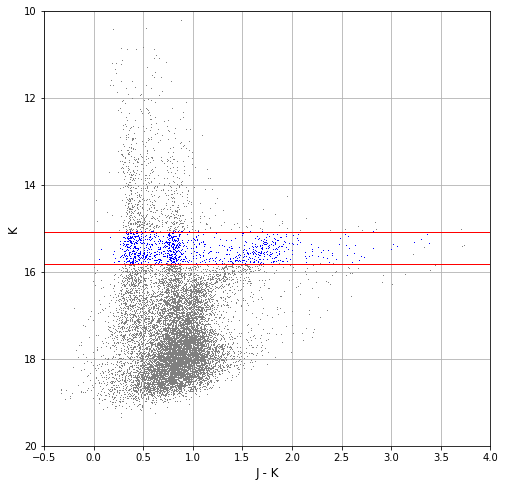

1001
0.1754736842105263
15.823
15.093


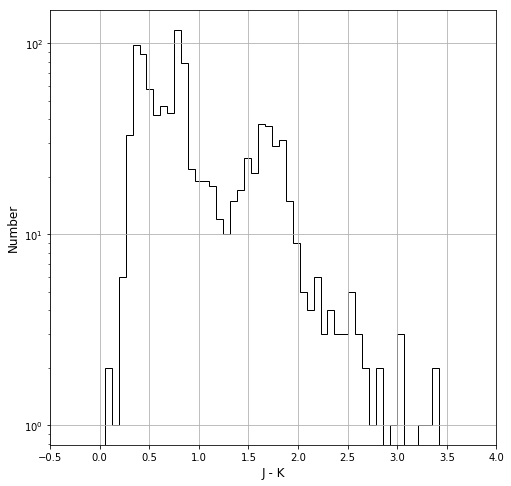

In [22]:
# 21 (Bin 5)

# Here I'm making the CMD of *ONLY* the sources within the fifth bin above the TRGB.
# Also I'm making a histogram of said sources.

TRGB = 15.823

jMINUSkHIST = low_error_jMINUSkDATA[(low_error_jMINUSkDATA.Kmag < (TRGB))
                                    & (low_error_jMINUSkDATA.Kmag > (TRGB-initial_width*1.-width_change*25.))]

bin_end = TRGB-initial_width*1.-width_change*23.

plt.figure(figsize=(8,8))
plt.plot(jMINUSkDATA.jMINUSk, jMINUSkDATA.Kmag, ',', color='gray')
plt.plot(jMINUSkHIST.jMINUSk, jMINUSkHIST.Kmag, ',', color='blue')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - K', size=12)
plt.ylabel('K', size=12)
#
plt.axhline(y=TRGB, linewidth=1.0, color='red') # Bin 5 - lower boundary
plt.axhline(y=bin_end, linewidth=1.0, color='red') # Bin 5 - upper boundary
#
plt.grid(True)
plt.show()
plt.close()

# define the range of K-band magnitudes over which the bin is sampling
# from the catalog of sources with K-mag and J-mag errors less than 0.1.
#
#print jMINUSkHIST
print(len(jMINUSkHIST))
#
binwidth = stats.knuth_bin_width(jMINUSkHIST.jMINUSk)
bin_number = (max(jMINUSkHIST.jMINUSk)+binwidth)/binwidth
print(binwidth)
#print bin_number
#
print(TRGB)
print(bin_end)
#
fig = plt.figure(figsize = (8,8))
plt.hist(jMINUSkHIST.jMINUSk, bins=np.arange(min(jMINUSkHIST.jMINUSk), max(jMINUSkHIST.jMINUSk) + binwidth/2.5, binwidth/2.5), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-0.5, 4.0)
plt.xlabel('J - K', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

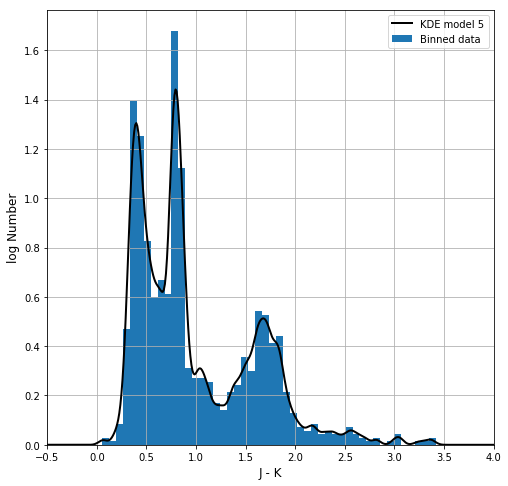

In [23]:
# 22 (Bin 5)

# K = 15.823 to 15.093
#
kde_data = jMINUSkHIST.jMINUSk.values
bins=np.arange(min(kde_data ), max(kde_data ) + binwidth/2.5, binwidth/2.5)
x_eval = np.linspace(kde_data.min() - 1.0, kde_data.max() + 1.0, 500)
kde = gaussian_kde(kde_data,bw_method=binwidth/2.5)
#
plt.figure(figsize=(8,8))
plt.plot(x_eval, kde(x_eval),'k',lw=2,label='KDE model 5')
plt.hist(kde_data,bins=bins,density=True,label='Binned data')
plt.xlim(-0.5, 4.0)

#plt.xlim(0.65, 0.68)
#plt.ylim(0.6, 0.65)
#plt.xlim(0.985, 0.987)
#plt.ylim(0.285, 0.287)
#plt.xlim(1.26, 1.27)
#plt.ylim(0.159, 0.160)
#plt.xlim(2.908, 2.912)
#plt.ylim(0.003, 0.0035)

plt.legend()
plt.xlabel('J - K', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()
#
### y-intercept: K_0 = 15.458
### boundary 1: J-K = 0.612 ? 0.665
### boundary 2: J-K = 0.986 ? 0.986
### boundary 3: J-K = 1.264 ? 1.264
### boundary 4: J-K = 2.910 ? 2.910

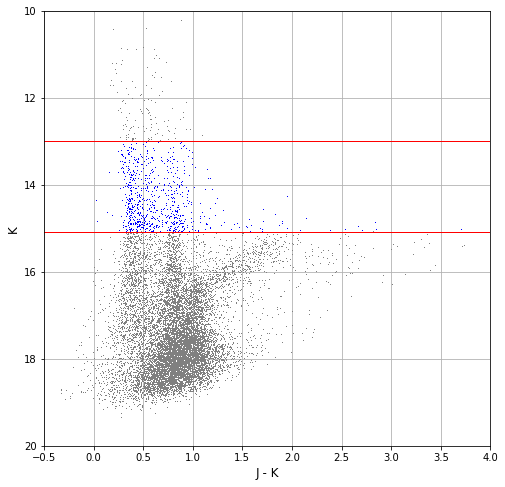

745
0.0782127659574468
15.093
13.0


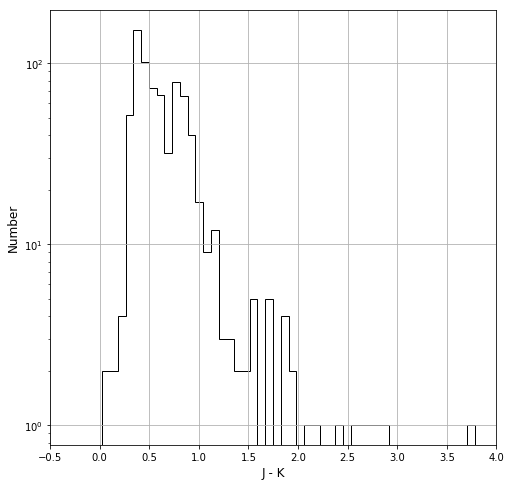

In [24]:
# 23 (Bin 6)

# Here I'm making the CMD of *ONLY* the sources within the sixth bin above the TRGB.
# Also I'm making a histogram of said sources.

TRGB = 15.093

jMINUSkHIST = low_error_jMINUSkDATA[(low_error_jMINUSkDATA.Kmag < (TRGB))
                                    & (low_error_jMINUSkDATA.Kmag > 13.)]

bin_end = 13.

plt.figure(figsize=(8,8))
plt.plot(jMINUSkDATA.jMINUSk, jMINUSkDATA.Kmag, ',', color='gray')
plt.plot(jMINUSkHIST.jMINUSk, jMINUSkHIST.Kmag, ',', color='blue')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - K', size=12)
plt.ylabel('K', size=12)
#
plt.axhline(y=TRGB, linewidth=1.0, color='red') # Bin 6 - lower boundary
plt.axhline(y=13.0, linewidth=1.0, color='red') # Bin 6 - upper boundary
#
plt.grid(True)
plt.show()
plt.close()

# define the range of K-band magnitudes over which the bin is sampling
# from the catalog of sources with K-mag and J-mag errors less than 0.1.
#
#print jMINUSkHIST
print(len(jMINUSkHIST))
#
binwidth = stats.knuth_bin_width(jMINUSkHIST.jMINUSk)
bin_number = (max(jMINUSkHIST.jMINUSk)+binwidth)/binwidth
print(binwidth)
#print bin_number
#
print(TRGB)
print(bin_end)
#
fig = plt.figure(figsize = (8,8))
plt.hist(jMINUSkHIST.jMINUSk, bins=np.arange(min(jMINUSkHIST.jMINUSk), max(jMINUSkHIST.jMINUSk) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-0.5, 4.0)
plt.xlabel('J - K', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

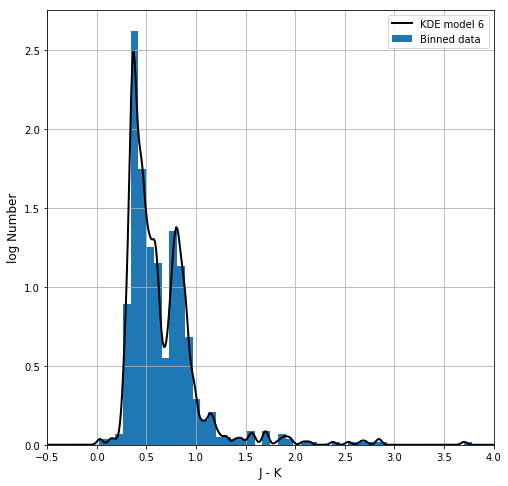

In [25]:
# 24 (Bin 6)

# K = 15.093 to 13.000
#
kde_data = jMINUSkHIST.jMINUSk.values
bins=np.arange(min(kde_data ), max(kde_data ) + binwidth, binwidth)
x_eval = np.linspace(kde_data.min() - 1.0, kde_data.max() + 1.0, 500)
kde = gaussian_kde(kde_data,bw_method=binwidth)
#
plt.figure(figsize=(8,8))
plt.plot(x_eval, kde(x_eval),'k',lw=2,label='KDE model 6')
plt.hist(kde_data,bins=bins,density=True,label='Binned data')
plt.xlim(-0.5, 4.0)

#plt.xlim(0.676, 0.677)
#plt.ylim(0.62, 0.621)
#plt.xlim(1.085, 1.0875)
#plt.ylim(0.153, 0.154)
#plt.xlim(2.25, 2.27)
#plt.ylim(0.0, 0.00001)

plt.legend()
plt.xlabel('J - K', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()
#
### y-intercept: K_0 = 14.0465
### boundary 1: J-K = 0.688 ? 0.676
### boundary 2: J-K = 1.075 ? 1.086
### boundary 3: J-K = 1.359 -> 1.791 -> 2.019 -> 2.269 ? 2.258
### boundary 4: J-K = XXX

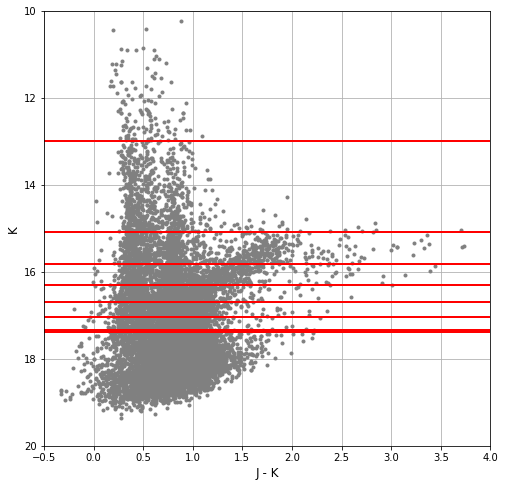

In [26]:
# 25

# K vs J-K
# CMD with color-points and lines
#
plt.figure(figsize=(8,8))
plt.plot(jMINUSkDATA.jMINUSk, jMINUSkDATA.Kmag, '.', color='gray')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - K', size=12)
plt.ylabel('K', size=12)
#
### where are the magnitude span bin midpoints?
#
#plt.axhline(y=17.203, linewidth=2.0, color='cyan')
#plt.axhline(y=16.863, linewidth=2.0, color='cyan')
#plt.axhline(y=16.488, linewidth=2.0, color='cyan')
#plt.axhline(y=16.058, linewidth=2.0, color='cyan')
#plt.axhline(y=15.458, linewidth=2.0, color='cyan')
#plt.axhline(y=14.0465, linewidth=2.0, color='cyan')
#
### where are the bin boundaries?
#
plt.axhline(y=17.363, linewidth=2.0, color='red')
plt.axhline(y=17.043, linewidth=2.0, color='red')
plt.axhline(y=16.683, linewidth=2.0, color='red')
plt.axhline(y=16.293, linewidth=2.0, color='red')
plt.axhline(y=15.823, linewidth=2.0, color='red')
plt.axhline(y=15.093, linewidth=2.0, color='red')
plt.axhline(y=13.000, linewidth=2.0, color='red')
#
### plot points
#
yvalues1 = np.array([17.203, 16.863, 16.488, 16.058, 15.458, 14.0465])
yvalues2 = np.array([17.203, 16.863, 16.488, 16.058, 15.458, 14.0465])
yvalues3 = np.array([17.203, 16.863, 16.488, 16.058, 15.458, 14.0465])
yvalues4 = np.array([17.203, 16.863, 16.488, 16.058, 15.458])
boundary1 = np.array([0.482, 0.543, 0.592, 0.575, 0.665, 0.676])
boundary2 = np.array([0.882, 0.910, 0.951, 0.949, 0.986, 1.086])
boundary3 = np.array([0.988, 1.114, 1.266, 1.127, 1.264, 2.258])
boundary4 = np.array([1.305, 1.408, 1.826, 2.306, 2.910])
#
#plt.plot(boundary1, yvalues1, linewidth=4.0, color='red')
#plt.plot(boundary2, yvalues2, linewidth=4.0, color='red')
#plt.plot(boundary3, yvalues3, linewidth=4.0, color='red')
#plt.plot(boundary4, yvalues4, linewidth=4.0, color='red')
#
plt.axhline(y=17.363, linewidth=4.0, color='red') # TRGB threshold
extremely_dusty = 2.094 # from previous analysis
#

plt.grid(True)
plt.show()
plt.close()
#plt.savefig('CMD1_bins.pdf')

-9.586324539372798 21.891625841797612
-128.3181818181806 100.78959090909008

-15.87998315922431 31.2747871549615

-2.568378861900523 19.734766668960322
3.0935251798560923 12.57159712230218
-4.379562043795606 20.99376642335764
-1.420020120724346 17.252905432595572

-3.3009708737863668 21.510766990291202
-0.9336714193622097 18.189130873402668


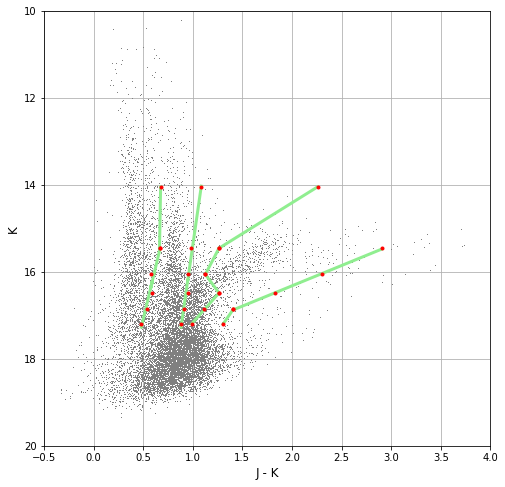

In [27]:
# 26

# Using the color-cut boundaries from the plot above,
# I can use the routine POLYFIT to fit functions,
# then use these functions to make logic statements
# to make the actual catalog cuts.

plt.figure(figsize=(8,8))
plt.plot(jMINUSkDATA.jMINUSk, jMINUSkDATA.Kmag, ',', color='gray')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - K', size=12)
plt.ylabel('K', size=12)

from numpy.polynomial.polynomial import polyfit

yvalues1a = np.array([17.203, 16.863, 16.488, 16.058, 15.458])
yvalues1b = np.array([15.458, 14.0465])

yvalues2a = np.array([17.203, 16.863, 16.488, 16.058, 15.458, 14.0465])

yvalues3a = np.array([17.203, 16.863, 16.488])
yvalues3b = np.array([16.488, 16.058])
yvalues3c = np.array([16.058, 15.458])
yvalues3d = np.array([15.458, 14.0465])

yvalues4a = np.array([17.203, 16.863])
yvalues4b = np.array([16.863, 16.488, 16.058, 15.458])

#

boundary1a = np.array([0.482, 0.543, 0.592, 0.575, 0.665])
boundary1b = np.array([0.665, 0.676])

boundary2a = np.array([0.882, 0.910, 0.951, 0.949, 0.986, 1.086])

boundary3a = np.array([0.988, 1.114, 1.266])
boundary3b = np.array([1.266, 1.127])
boundary3c = np.array([1.127, 1.264])
boundary3d = np.array([1.264, 2.258])

boundary4a = np.array([1.305, 1.408])
boundary4b = np.array([1.408, 1.826, 2.306, 2.910])

#

b1a, m1a = polyfit(boundary1a, yvalues1a, 1)
b1b, m1b = polyfit(boundary1b, yvalues1b, 1)

b2a, m2a = polyfit(boundary2, yvalues2, 1)

b3a, m3a = polyfit(boundary3a, yvalues3a, 1)
b3b, m3b = polyfit(boundary3b, yvalues3b, 1)
b3c, m3c = polyfit(boundary3c, yvalues3c, 1)
b3d, m3d = polyfit(boundary3d, yvalues3d, 1)

b4a, m4a = polyfit(boundary4a, yvalues4a, 1)
b4b, m4b = polyfit(boundary4b, yvalues4b, 1)

#

print(m1a, b1a)
print(m1b, b1b)
print('')
print(m2a, b2a)
print('')
print(m3a, b3a)
print(m3b, b3b)
print(m3c, b3c)
print(m3d, b3d)
print('')
print(m4a, b4a)
print(m4b, b4b)

#

plt.plot(boundary1a, b1a + m1a * boundary1a, '-', linewidth=3.0, color='lightgreen')
plt.plot(boundary1b, b1b + m1b * boundary1b, '-', linewidth=3.0, color='lightgreen')

plt.plot(boundary2a, b2a + m2a * boundary2a, '-', linewidth=3.0, color='lightgreen')

plt.plot(boundary3a, b3a + m3a * boundary3a, '-', linewidth=3.0, color='lightgreen')
plt.plot(boundary3b, b3b + m3b * boundary3b, '-', linewidth=3.0, color='lightgreen')
plt.plot(boundary3c, b3c + m3c * boundary3c, '-', linewidth=3.0, color='lightgreen')
plt.plot(boundary3d, b3d + m3d * boundary3d, '-', linewidth=3.0, color='lightgreen')

plt.plot(boundary4a, b4a + m4a * boundary4a, '-', linewidth=3.0, color='lightgreen')
plt.plot(boundary4b, b4b + m4b * boundary4b, '-', linewidth=3.0, color='lightgreen')

#

plt.plot(boundary1a, yvalues1a, '.', color='red')
plt.plot(boundary1b, yvalues1b, '.', color='red')

plt.plot(boundary2a, yvalues2a, '.', color='red')

plt.plot(boundary3a, yvalues3a, '.', color='red')
plt.plot(boundary3b, yvalues3b, '.', color='red')
plt.plot(boundary3c, yvalues3c, '.', color='red')
plt.plot(boundary3d, yvalues3d, '.', color='red')

plt.plot(boundary4a, yvalues4a, '.', color='red')
plt.plot(boundary4b, yvalues4b, '.', color='red')

#

plt.grid(True)
plt.show()
plt.close()

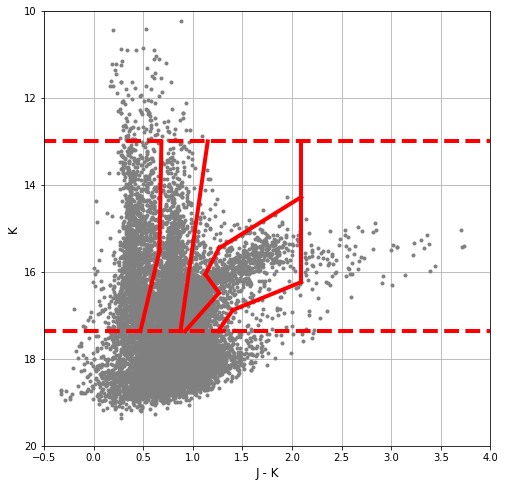

In [28]:
# 27

# With the lines defined by POLYFIT,
# I will now define final boundaries.

plt.figure(figsize=(8,8))
plt.plot(jMINUSkDATA.jMINUSk, jMINUSkDATA.Kmag, '.', color='gray')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - K', size=12)
plt.ylabel('K', size=12)

# TRGB limit
#
x_TRGB = np.linspace(-1.0, 5.0, 100)
y_TRGB = 0.0*x_TRGB + 17.363

# brightness limit
#
x_bright = np.linspace(-1.0, 5.0, 100)
y_bright = 0.0*x_bright + 13.0

# dusty limit
#
extremely_dusty = 2.094 # from previous analysis

# Boundary 1
#
x_Boundary1a = np.linspace(0.472405, 0.6645054400355514, 100)
y_Boundary1a = -9.586324539372798*x_Boundary1a + 21.891625841797612

x_Boundary1b = np.linspace(0.6645054400355514, 0.684156, 100)
y_Boundary1b = -128.3181818181806*x_Boundary1b + 100.78959090909008

# Boundary 2
#
x_Boundary2a = np.linspace(0.876058, 1.15081, 100)
y_Boundary2a = -15.87998315922431*x_Boundary2a + 31.2747871549615

# Boundary 3
#
x_Boundary3a = np.linspace(0.923449, 1.265152057299042, 100)
y_Boundary3a = -2.568378861900523*x_Boundary3a + 19.734766668960322

x_Boundary3b = np.linspace(1.265152057299042, 1.126999999999999, 100)
y_Boundary3b = 3.0935251798560923*x_Boundary3b + 12.57159712230218

x_Boundary3c = np.linspace(1.126999999999999, 1.263999999999998, 100)
y_Boundary3c = -4.379562043795606*x_Boundary3c + 20.99376642335764

x_Boundary3d = np.linspace(1.263999999999998, 2.094, 100)
y_Boundary3d = -1.420020120724346*x_Boundary3d + 17.252905432595572

# Boundary 4
#
x_Boundary4a = np.linspace(1.25653, 1.403133055550219, 100)
y_Boundary4a = -3.3009708737863668*x_Boundary4a + 21.510766990291202

x_Boundary4b = np.linspace(1.403133055550219, 2.094, 100)
y_Boundary4b = -0.9336714193622097*x_Boundary4b + 18.189130873402668

# plot lines
#
plt.plot(x_TRGB, y_TRGB, '--', linewidth=4.0, color='red')
plt.plot(x_bright, y_bright, '--', linewidth=4.0, color='red')

plt.plot(x_Boundary1a, y_Boundary1a, linewidth=4.0, color='red')
plt.plot(x_Boundary1b, y_Boundary1b, linewidth=4.0, color='red')

plt.plot(x_Boundary2a, y_Boundary2a, linewidth=4.0, color='red')

plt.plot(x_Boundary3a, y_Boundary3a, linewidth=4.0, color='red')
plt.plot(x_Boundary3b, y_Boundary3b, linewidth=4.0, color='red')
plt.plot(x_Boundary3c, y_Boundary3c, linewidth=4.0, color='red')
plt.plot(x_Boundary3d, y_Boundary3d, linewidth=4.0, color='red')

plt.plot(x_Boundary4a, y_Boundary4a, linewidth=4.0, color='red')
plt.plot(x_Boundary4b, y_Boundary4b, linewidth=4.0, color='red')

y_extremely_dusty = np.linspace(16.234, 13.0, 100)
x_extremely_dusty = 0.0*y_extremely_dusty + extremely_dusty
plt.plot(x_extremely_dusty, y_extremely_dusty, linewidth=4.0, color='red')

plt.grid(True)
plt.show()
plt.close()
#plt.savefig('CMD1_boundaries.pdf')

1636
2075
1002
907
144


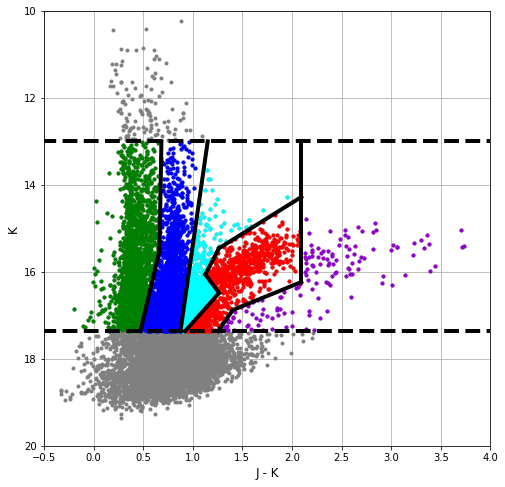

In [29]:
# 28

# Now that I have my boundaies, my next task is to chop up the
# master catalog to get the different population lists.

#
CMD1_region1 = pd.read_csv('CMD1_region1.csv')
CMD1_region2 = pd.read_csv('CMD1_region2.csv')
CMD1_region3 = pd.read_csv('CMD1_region3.csv')
CMD1_region4 = pd.read_csv('CMD1_region4.csv')
CMD1_region5 = pd.read_csv('CMD1_region5.csv')
#
print(len(CMD1_region1))
print(len(CMD1_region2))
print(len(CMD1_region3))
print(len(CMD1_region4))
print(len(CMD1_region5))

# CMD_1 (K vs J-K)

plt.figure(figsize=(8,8))
plt.plot(jMINUSkDATA.jMINUSk, jMINUSkDATA.Kmag, '.', color='gray')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - K', size=12)
plt.ylabel('K', size=12)

plt.plot(CMD1_region1.jMINUSk, CMD1_region1.Kmag, '.', color='green')
plt.plot(CMD1_region2.jMINUSk, CMD1_region2.Kmag, '.', color='blue')
plt.plot(CMD1_region3.jMINUSk, CMD1_region3.Kmag, '.', color='cyan')
plt.plot(CMD1_region4.jMINUSk, CMD1_region4.Kmag, '.', color='red')
plt.plot(CMD1_region5.jMINUSk, CMD1_region5.Kmag, '.', color='darkviolet')

##########

# TRGB limit
#
x_TRGB = np.linspace(-1.0, 5.0, 100)
y_TRGB = 0.0*x_TRGB + 17.363

# brightness limit
#
x_bright = np.linspace(-1.0, 5.0, 100)
y_bright = 0.0*x_bright + 13.0

# dusty limit
#
extremely_dusty = 2.094 # from previous analysis

# Boundary 1
#
x_Boundary1a = np.linspace(0.472405, 0.6645054400355514, 100)
y_Boundary1a = -9.586324539372798*x_Boundary1a + 21.891625841797612

x_Boundary1b = np.linspace(0.6645054400355514, 0.684156, 100)
y_Boundary1b = -128.3181818181806*x_Boundary1b + 100.78959090909008

# Boundary 2
#
x_Boundary2a = np.linspace(0.876058, 1.15081, 100)
y_Boundary2a = -15.87998315922431*x_Boundary2a + 31.2747871549615

# Boundary 3
#
x_Boundary3a = np.linspace(0.923449, 1.265152057299042, 100)
y_Boundary3a = -2.568378861900523*x_Boundary3a + 19.734766668960322

x_Boundary3b = np.linspace(1.265152057299042, 1.126999999999999, 100)
y_Boundary3b = 3.0935251798560923*x_Boundary3b + 12.57159712230218

x_Boundary3c = np.linspace(1.126999999999999, 1.263999999999998, 100)
y_Boundary3c = -4.379562043795606*x_Boundary3c + 20.99376642335764

x_Boundary3d = np.linspace(1.263999999999998, 2.094, 100)
y_Boundary3d = -1.420020120724346*x_Boundary3d + 17.252905432595572

# Boundary 4
#
x_Boundary4a = np.linspace(1.25653, 1.403133055550219, 100)
y_Boundary4a = -3.3009708737863668*x_Boundary4a + 21.510766990291202

x_Boundary4b = np.linspace(1.403133055550219, 2.094, 100)
y_Boundary4b = -0.9336714193622097*x_Boundary4b + 18.189130873402668

# plot lines
#
plt.plot(x_TRGB, y_TRGB, '--', linewidth=4.0, color='black')
plt.plot(x_bright, y_bright, '--', linewidth=4.0, color='black')

plt.plot(x_Boundary1a, y_Boundary1a, linewidth=4.0, color='black')
plt.plot(x_Boundary1b, y_Boundary1b, linewidth=4.0, color='black')

plt.plot(x_Boundary2a, y_Boundary2a, linewidth=4.0, color='black')

plt.plot(x_Boundary3a, y_Boundary3a, linewidth=4.0, color='black')
plt.plot(x_Boundary3b, y_Boundary3b, linewidth=4.0, color='black')
plt.plot(x_Boundary3c, y_Boundary3c, linewidth=4.0, color='black')
plt.plot(x_Boundary3d, y_Boundary3d, linewidth=4.0, color='black')

plt.plot(x_Boundary4a, y_Boundary4a, linewidth=4.0, color='black')
plt.plot(x_Boundary4b, y_Boundary4b, linewidth=4.0, color='black')

y_extremely_dusty = np.linspace(16.234, 13.0, 100)
x_extremely_dusty = 0.0*y_extremely_dusty + extremely_dusty
plt.plot(x_extremely_dusty, y_extremely_dusty, linewidth=4.0, color='black')

plt.grid(True)
plt.show()
plt.close()
#plt.savefig('CMD1_populations.pdf')